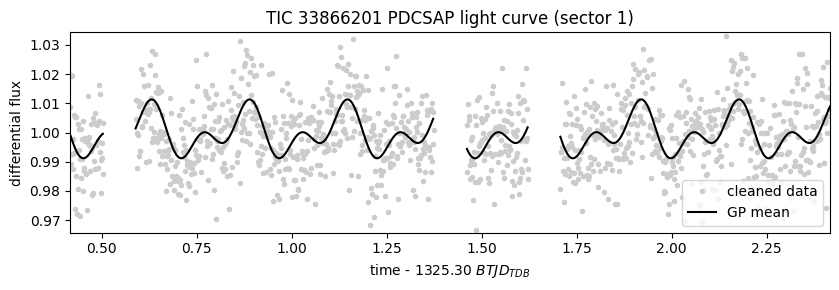

In [13]:
import pickle

import jax
import matplotlib.pyplot as plt
import numpy as np
import yaml
from nuance import Nuance
from nuance.kernels import rotation

target = 33866201 
raw_data = f"../data/{target}/original.fluxes"
data_path = f"../data/{target}/cleaned.fluxes"
gp_path = f"../data/{target}/gp.yaml"
info_path = f"../data/{target}/info.yaml"


original_data = pickle.load(open(raw_data, "rb"))
data = pickle.load(open(data_path, "rb"))
gp_params = yaml.full_load(open(gp_path, "r"))
info = yaml.full_load(open(info_path, "r"))

build_gp, init = rotation(info["star_period"], np.mean(data["error"]), long_scale=0.5)
gp = build_gp(gp_params, data["time"])

nu = Nuance(data["time"], data["flux"], gp=gp)
optimize, mu, nll = nu.gp_optimization(build_gp)
gp_mean = mu(gp_params)

plt.figure(None, (8.5, 3))
plt.xlabel(f"time - {info['time0']:.2f} ${info['time0_format']}$")
plt.ylabel("differential flux")
plt.title(f"TIC {info['tic']} PDCSAP light curve (sector {int(info['sector'])})")
plt.plot(data["time"], data["flux"], ".", c="0.8", label="cleaned data")
gp_mean = mu(gp_params)
idxs = [0, *np.flatnonzero(np.diff(data["time"]) > 10 / 60 / 24), len(data["time"])]
for i in range(len(idxs) - 1):
    x = data["time"][idxs[i] + 1 : idxs[i + 1]]
    y = gp_mean[idxs[i] + 1 : idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if i == 0 else None)
plt.legend(loc="lower right")
plt.xlim(data["time"][0], data["time"][0] + 2)
std = np.std(data["flux"]) * 3
plt.ylim(1 - std, 1 + std)

plt.tight_layout()

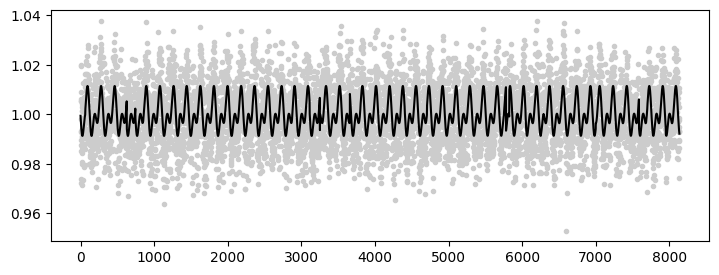

In [14]:
plt.figure(None, (8.5, 3))

plt.plot(data["flux"], ".", c="0.8", label="cleaned data")
plt.plot(gp_mean, "k", label="GP mean" if i == 0 else None)

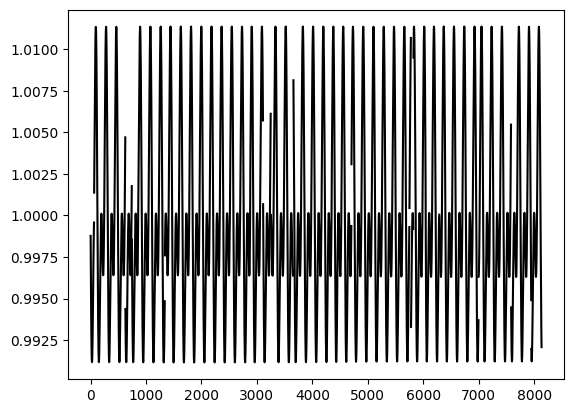

In [47]:
idxs = np.flatnonzero(np.diff(data["time"]) > 4*np.median(np.diff(data["time"])))
idxs = [0, *idxs, len(data["time"])]

for i in range(len(idxs) - 1):
    x = np.arange(idxs[i] + 1, idxs[i + 1])
    y = gp_mean[idxs[i] + 1 : idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if i == 0 else None)

(0.4166659824572889, 12.808301125445723)

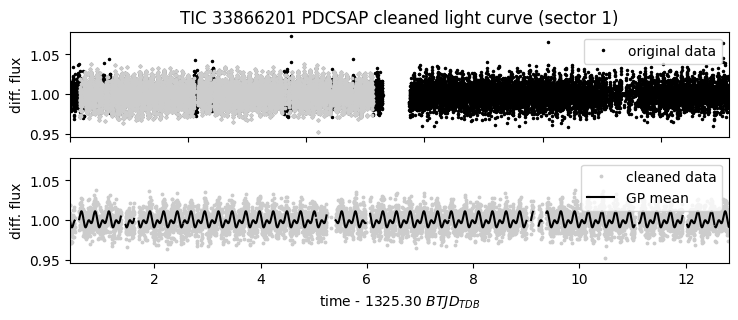

In [62]:
ylim = 7*np.std(data["flux"]) * np.array([-1, 1]) + 1 

plt.figure(None, (8.5, 3))
ax = plt.subplot(211)
ax.xaxis.set_ticklabels([])
ax.set_title(f"TIC {info['tic']} PDCSAP cleaned light curve (sector {int(info['sector'])})")
plt.plot(original_data["time"], original_data["flux"], ".", c="k", label="original data", ms=3)
plt.plot(data["time"], data["flux"], ".", c="0.8", ms=3.5)
plt.ylabel("diff. flux")
plt.xlim(original_data["time"][0], original_data["time"][-1])
ylim = plt.ylim()
plt.legend()

plt.subplot(212)
plt.plot(data["time"], data["flux"], ".", c="0.8", label="cleaned data", ms=3.5)

split_idxs = [
    0,
    *np.flatnonzero(np.diff(data["time"]) > 10 / 60 / 24),
    len(data["time"]),
]

_ = True
for i in range(len(split_idxs) - 1):
    x = data["time"][split_idxs[i] + 1 : split_idxs[i + 1]]
    y = gp_mean[split_idxs[i] + 1 : split_idxs[i + 1]]
    plt.plot(x, y, "k", label="GP mean" if _ else None)
    _ = False

plt.xlim(data["time"][0], data["time"][-1])
plt.legend()
plt.ylabel("diff. flux")
plt.ylim(ylim)
plt.xlabel(f"time - {info['time0']:.2f} ${info['time0_format']}$")
plt.xlim(data["time"][0], data["time"][-1])
